In [34]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, page_map, quest_map, attention, did_map
from scipy.stats import shapiro, yeojohnson, kruskal
import scikit_posthocs as sp
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json

In [35]:
def get_pvalue(x):
    return round(shapiro(x).pvalue, 5)

In [36]:
page_id = '7'
password_response, time_response, survey_response, dids = get_responses()
questions = get_questions()

Total: 119; 
Attentive: 103; Non Attentive: 16


In [37]:
survey_response_df = pd.DataFrame(survey_response)

quest = pd.json_normalize(survey_response_df[page_id]).astype(float)
quest.drop(attention.get(page_id).keys(), axis=1, inplace=True)
# normalize low and high likert scale values
normqsid = ['1-2', '1-4', '1-7', '1-10', '1-12', '1-13', '1-16']
normquest = 8 - quest[normqsid]
quest.update(normquest)

# normalize scale 1 to 8 to scale -3 to 3
normquest = quest - 4
quest.update(normquest)

new_columns = {}
for qsid in quest.columns:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_columns[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"')).get('elements').get(likert_scale)
quest.rename(columns=new_columns, inplace=True)

# display(quest.head())
# display(quest.describe())

## Ranking of Each Categories 

In [38]:
cats = {}
for k, v in quest_map.items():
    temp = quest[v]
    cats[k] = temp.mean(axis=1).to_dict()
quest = pd.DataFrame(cats)
quest['did'] = dids
quest['design'] = quest['did'].apply(lambda x: get_design(x))
quest.drop('did', axis=1, inplace=True)
display(quest)
display(quest.describe())

,Perspicuity,Aesthetics,Usefulness,Clarity,design
0,2.25,0.50,2.75,3.00,infographics
1,2.75,2.75,2.75,2.50,conversation
2,2.50,1.75,2.00,2.25,reflection
3,1.00,1.50,2.00,1.25,reflection
4,-1.25,-1.00,-1.75,-0.25,conversation
...,...,...,...,...,...
98,3.00,3.00,3.00,3.00,reflection
99,-0.75,-1.00,-0.50,-0.25,infographics
100,1.75,0.75,2.25,2.25,reflection
101,3.00,2.50,2.50,2.25,conversation


,Perspicuity,Aesthetics,Usefulness,Clarity
count,103.000000,103.000000,103.000000,103.000000
mean,1.572816,1.150485,1.570388,1.798544
std,1.174500,1.166495,1.304882,1.031999
min,-1.250000,-2.750000,-2.750000,-0.750000
25%,0.750000,0.500000,0.625000,1.250000
50%,1.750000,1.000000,2.000000,2.000000
75%,2.625000,2.000000,2.750000,2.750000
max,3.000000,3.000000,3.000000,3.000000


### Average of categories based on designs

In [39]:
did_quest = quest.groupby('design').mean()
did_quest

,Perspicuity,Aesthetics,Usefulness,Clarity
design,,,,
conversation,1.701923,1.538462,1.663462,1.807692
infographics,1.336538,0.480769,1.528846,1.769231
onlinechat,1.346154,1.153846,1.211538,1.663462
reflection,1.920000,1.440000,1.890000,1.960000


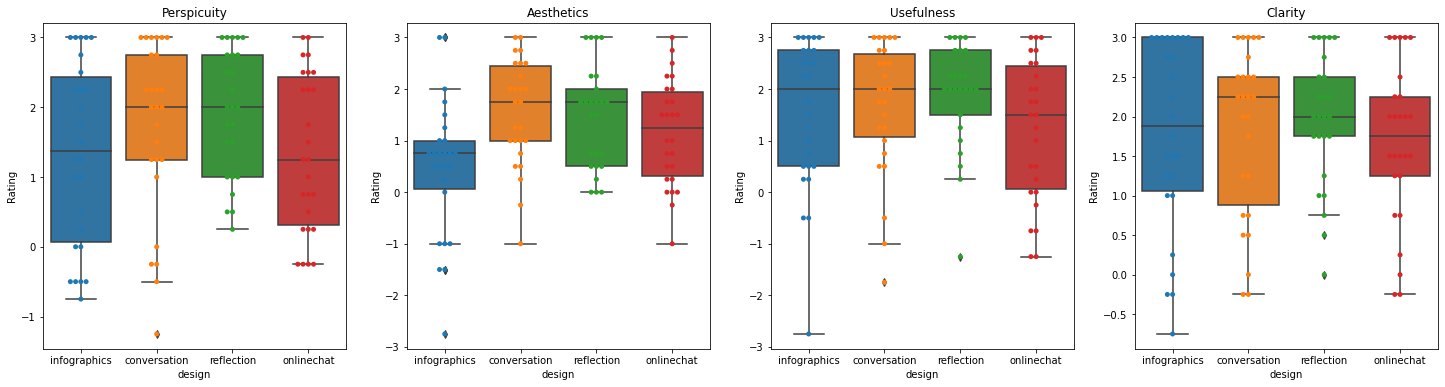

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
for i, param in enumerate(quest_map):
    sns.boxplot(data=quest, x='design', y=param, ax=axes[i])
    sns.swarmplot(data=quest, x='design', y=param, ax=axes[i])
    axes[i].set_ylabel('Rating')
    axes[i].set_title(param)

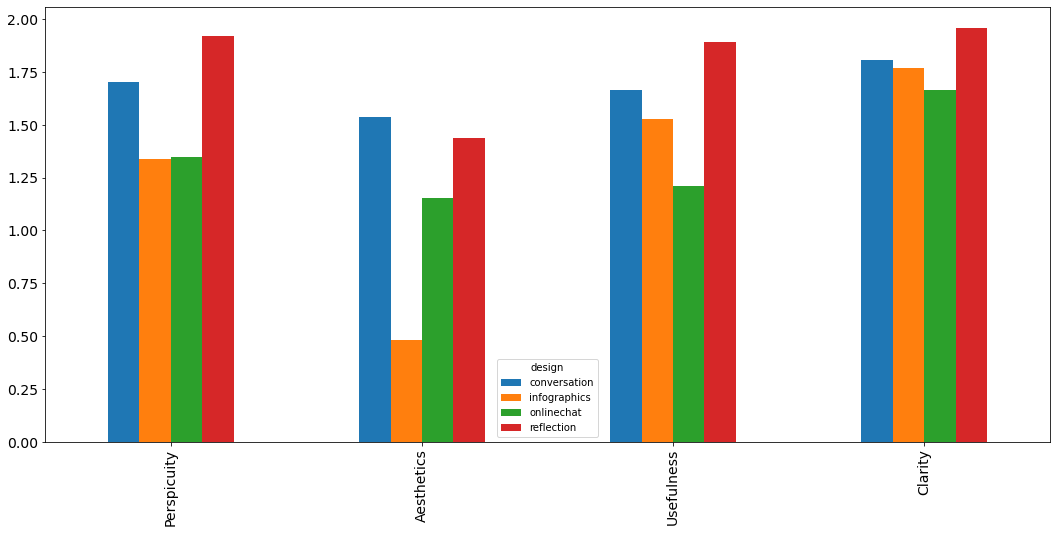

In [41]:
chart = did_quest.T.plot.bar(figsize=(18, 8), fontsize=14, style=".-")

## Significance Text

In [42]:
data = quest

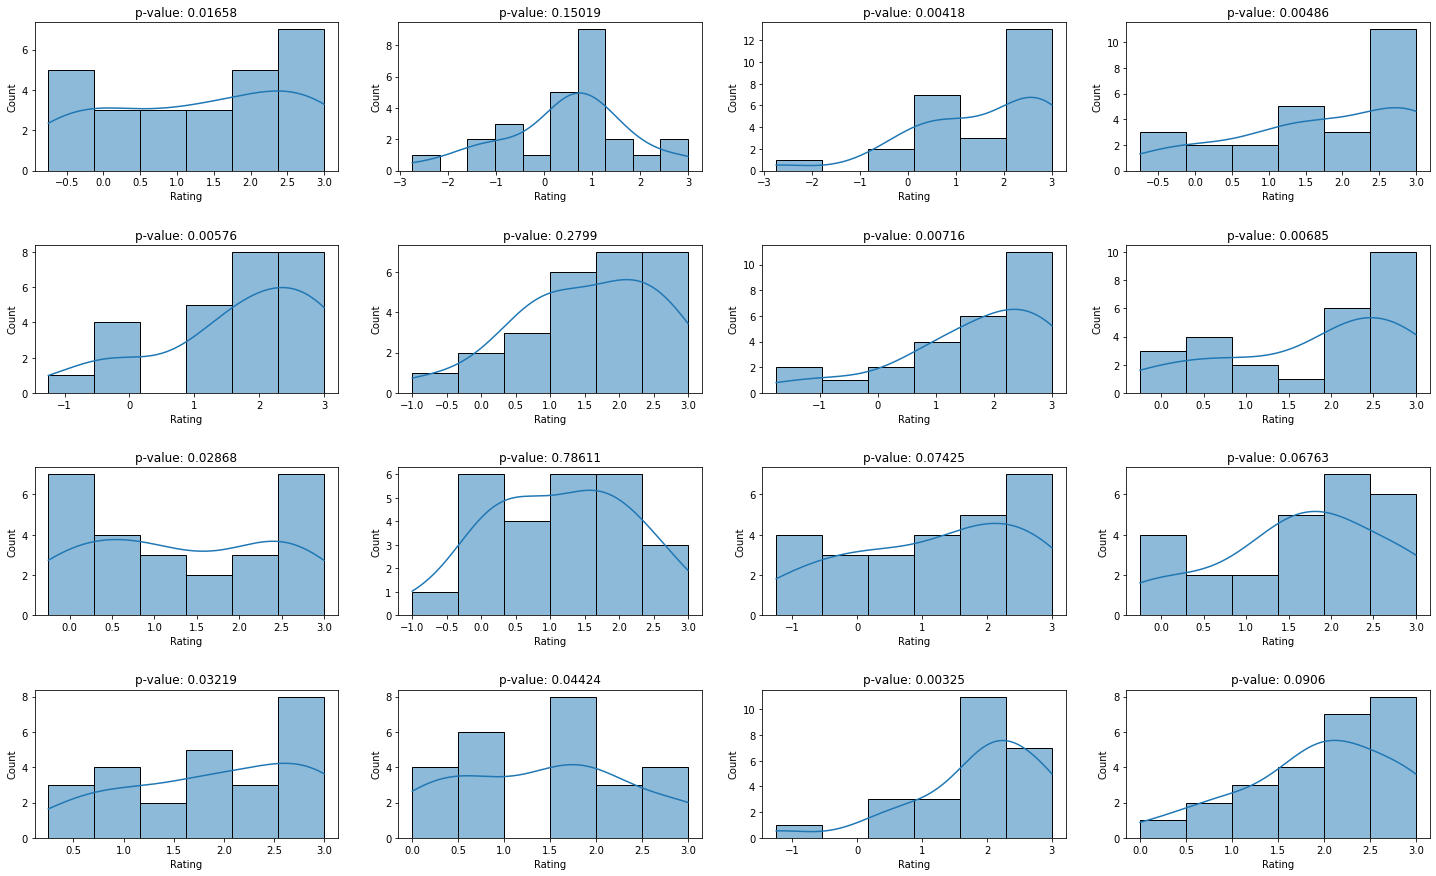

In [43]:
fig, axes = plt.subplots(4, 4, figsize=(25, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

for i, design in enumerate(did_map.values()):
    for j, param in enumerate(quest_map):
        fdata = data[data['design']==design]
        sns.histplot(data=fdata, x=param, kde=True, ax=axes[i][j])
        axes[i][j].set_xlabel('Rating')
        axes[i][j].set_title(f'p-value: {get_pvalue(fdata[param])}')

In [44]:
test = {}
designs = []
for i, param in enumerate(quest_map):
    test[param] = []
    for design in did_map.values():
        test[param].append(data[data['design']==design][param].to_list())
        designs.append(design) if i<=0 else None

# Performing kruskal test
for k, v in test.items():
    print(f'{k}: {kruskal(*v)}')

Perspicuity: KruskalResult(statistic=4.010907470602302, pvalue=0.26028872643326895)
Aesthetics: KruskalResult(statistic=10.734275635143254, pvalue=0.01325304752394556)
Usefulness: KruskalResult(statistic=3.2099624741569905, pvalue=0.36037205679407025)
Clarity: KruskalResult(statistic=0.9496633971784202, pvalue=0.813429303146023)


In [45]:
sp.posthoc_dunn(test['Aesthetics'])

,1,2,3,4
1,1.000000,0.002050,0.101652,0.013767
2,0.002050,1.000000,0.148187,0.555730
3,0.101652,0.148187,1.000000,0.399494
4,0.013767,0.555730,0.399494,1.000000


In [46]:
designs

['infographics', 'conversation', 'onlinechat', 'reflection']